In [1]:
library(easystats) # for visualization of posterior distribution and its derivatives
library(tidyverse)

theme_set(theme_minimal())

# Attaching packages
✔ insight     0.8.4.1   ✔ bayestestR  0.7.2  
✔ performance 0.4.6.1   ✔ parameters  0.7.0.1
✔ effectsize  0.3.1.1   ✔ modelbased  0.2.0  
✔ correlation 0.2.1     ✔ see         0.5.0.1



── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   0.8.5
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


# Bayesian inference: coin toss example

## Beta prior

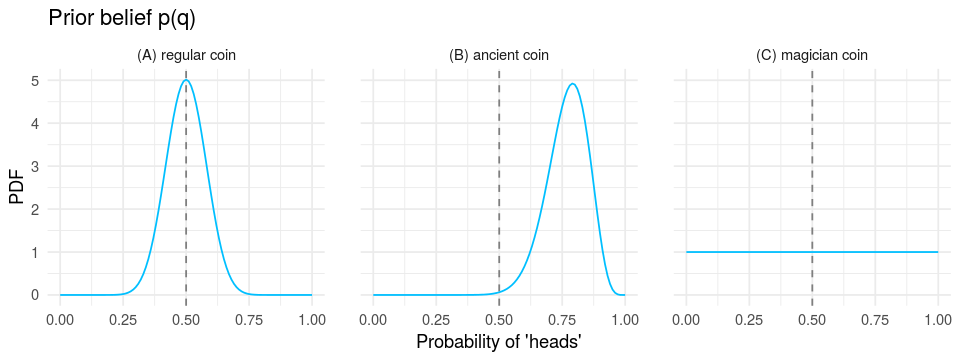

In [45]:
# Imagine you have a coin and want to assess how (un)fair it is.
# Even before you test it, you hold some (implicit) belief about it. Imagine 3 different scenarios:
# (A) You found the coin in your pocket, it's a regular one, you have a strong expectation that it's fair.
# (B) It's an ancient coin made of 2 different metals, heavier on the tails side. Therefore you expect 
#    it might be slightly bias towards heads.
# (C) You have been handed the coin by a magician to check it's normal. It does look normal, but you suspect
#    it's a rigged one, heavily biased towards one side or the other, only you don't know which one.

# Let's represent your prior belief as a Beta distribution over q, the probability of the coin landing heads,
# under the 2 different scenarios
x = seq(0,1,.01)
df.prior = data.frame(x = rep(x,3),
                      prior = c(dbeta(x,20,20),dbeta(x,20,6),dbeta(x,1,1)),
                      scenario = c(rep("A",length(x)),rep("B",length(x)),rep("C",length(x))))

scenario.labels = c("A"="(A) regular coin", "B"="(B) ancient coin", "C"="(C) magician coin")

options(repr.plot.width = 8, repr.plot.height = 3)

ggplot(df.prior, aes(y = prior, x = x)) +
facet_wrap(~ scenario, labeller = labeller(scenario = scenario.labels)) +
geom_vline(xintercept = .5, linetype = 2, color = "grey50") +
geom_line(color = "deepskyblue") +
labs(x = "Probability of 'heads'", y = "PDF", title = "Prior belief p(q)") +
theme(panel.spacing = unit(0.3,"in"))

## Likelihood

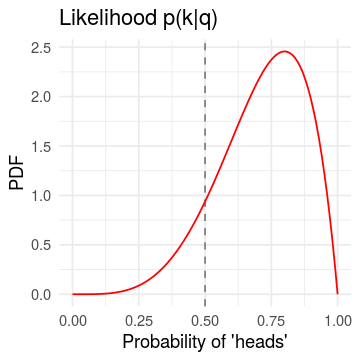

In [14]:
# Now imagine we toss the coin 50 times and get 38 heads
n = 5
k = 4

scaling = 1/(n+1) # this allows the likelihood to behave like a pdf, i.e. integrate to 1

# Let's visualize the *likelihood function* of the data for all possible values of q
df.likelihood = data.frame(x = x,
                           likelihood = dbinom(k, n, x)/scaling)

options(repr.plot.width = 3, repr.plot.height = 3)

ggplot(df.likelihood, aes(y = likelihood, x = x)) +
geom_vline(xintercept = .5, linetype = 2, color = "grey50") +
geom_line(color = "red") +
labs(x = "Probability of 'heads'", y = "PDF", title = "Likelihood p(k|q)")


## Posterior

Joining, by = c("x", "scenario")
Joining, by = "x"


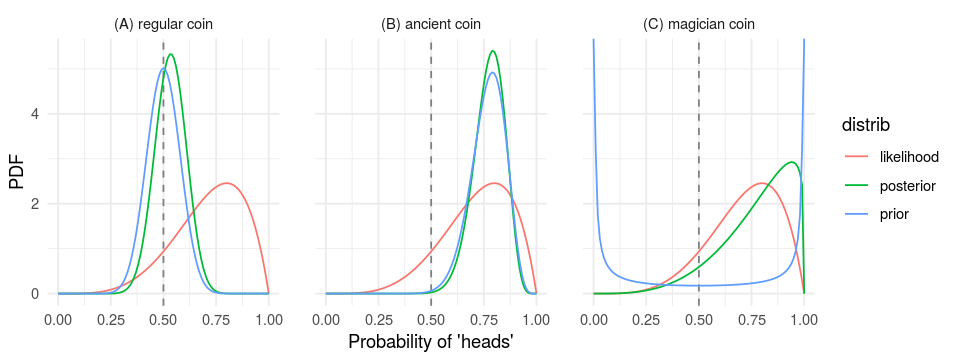

In [15]:
# Finally, we can combine the likelihood and prior under each of the 3 scenarios and obtain 
# the corresponding posterior beliefs

# Calculate the posterior
df.posterior = data.frame(x = rep(x,3),
                          posterior = c(dbeta(x,20+k,20+n-k),dbeta(x,20+k,6+n-k),dbeta(x,0.2+k,0.2+n-k)),
                          scenario = c(rep("A",length(x)),rep("B",length(x)),rep("C",length(x))))

# Join all distributions in a signle dataframe for convenience
df.all <- df.prior %>% full_join(df.posterior) %>% full_join(df.likelihood) %>% 
    gather(key = distrib, value = pdf, prior,likelihood,posterior)


# Plot
options(repr.plot.width = 8, repr.plot.height = 3)

ggplot(df.all, aes(x = x, y = pdf, color = distrib)) +
facet_wrap(~ scenario, labeller = labeller(scenario = scenario.labels)) +
geom_vline(xintercept = .5, linetype = 2, color = "grey50") +
geom_line() +
labs(x = "Probability of 'heads'", y = "PDF") +
theme(panel.spacing = unit(0.3,"in"))

## Point estimates

# Point Estimates

Median | Mean |  MAP
--------------------
  0.53 | 0.53 | 0.53



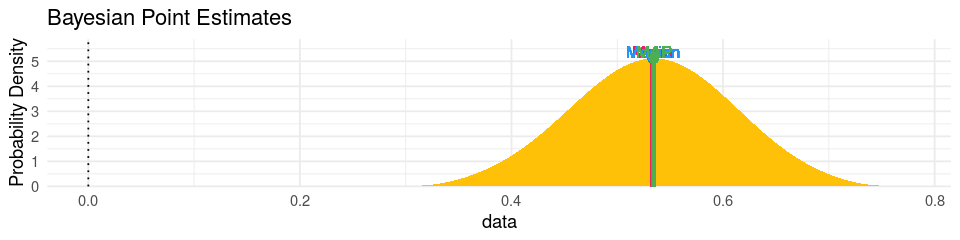

In [18]:
n = 5
k = 4

options(repr.plot.width = 4, repr.plot.height = 3)

# Scenario A (regular coin)
point_estimate(distribution_beta(100, 20+k,20+n-k)) %T>% print() %>% plot() 

# Point Estimates

Median | Mean |  MAP
--------------------
  0.78 | 0.77 | 0.79



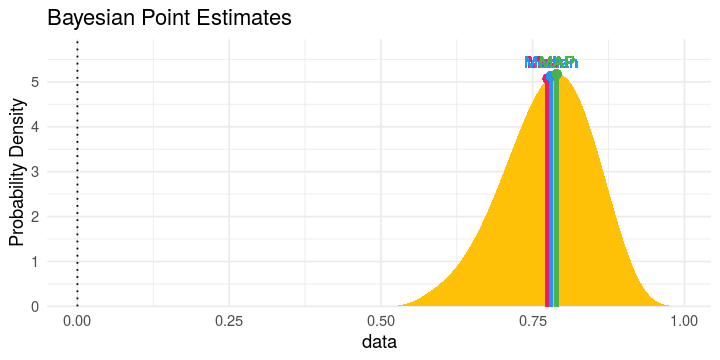

In [47]:
# Scenario B (ancient coin)
options(repr.plot.width = 6, repr.plot.height = 3)
point_estimate(distribution_beta(100, 20+k,6+n-k)) %T>% print() %>% plot()  

# Point Estimates

Median | Mean |  MAP
--------------------
  0.81 | 0.78 | 0.94



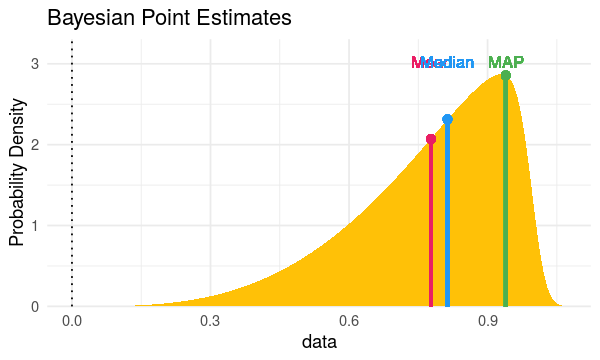

In [49]:
# Scenario C (magician coin)
options(repr.plot.width = 5, repr.plot.height = 3)
point_estimate(distribution_beta(10000, 0.2+k,0.2+n-k)) %T>% print() %>% plot()  

## Credible intervals
See https://easystats.github.io/bayestestR/articles/credible_interval.html

CI CI_low    CI_high  
1 90 0.5402892 0.9998828

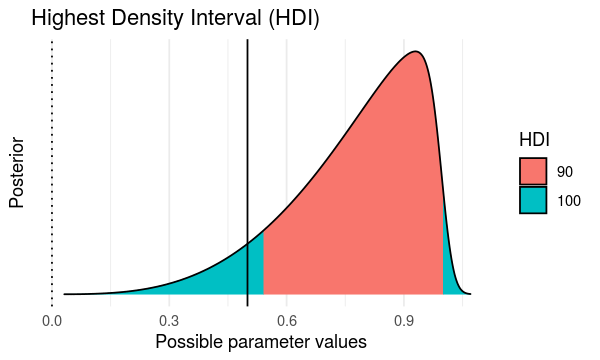

In [51]:
n = 5
k = 4

options(repr.plot.width = 5, repr.plot.height = 3)

# Scenario C (magician coin)
posterior = distribution_beta(10000, 0.2+k, 0.2+n-k)
ci = hdi(posterior, ci = 0.90) 
ci
plot(ci) + geom_vline(xintercept=.5)

CI CI_low   CI_high 
1 90 0.797397 0.945282

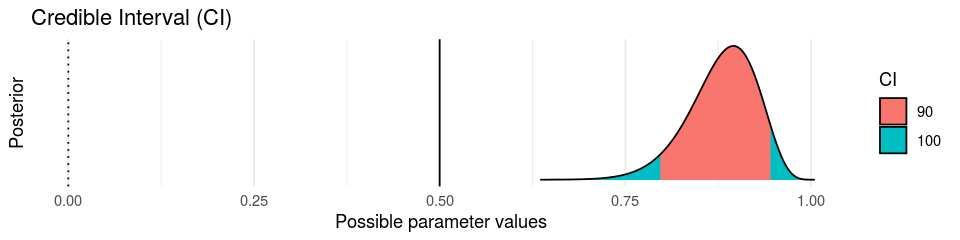

In [44]:
ci = eti(posterior, ci = .90)
ci
plot(ci) + geom_vline(xintercept=.5)

# Bayesian hypothesis testing

## Based on the posterior

### Exact hypothesis

In [58]:
# Scenario A (regular coin)
n = 5
k = 4
posterior = distribution_beta(10000, 20+k, 20+n-k)
p_pointnull(posterior-.5)

p (MAP) = 0.903

In [59]:
# Scenario B (ancient coin)
n = 5
k = 4
posterior = distribution_beta(10000, 20+k, 6+n-k)
p_pointnull(posterior-.5)

p (MAP) = 0.005

In [60]:
# Scenario C (magician's coin)
n = 5
k = 4
posterior = distribution_beta(10000, 0.2+k, 0.2+n-k)
p_pointnull(posterior-.5)

p (MAP) = 0.204

### Range hypothesis

#### Direction of effect
Empirically, this is highly correlated to the frequentist p-value (see https://easystats.github.io/bayestestR/articles/probability_of_direction.html)

pd = 88.99%

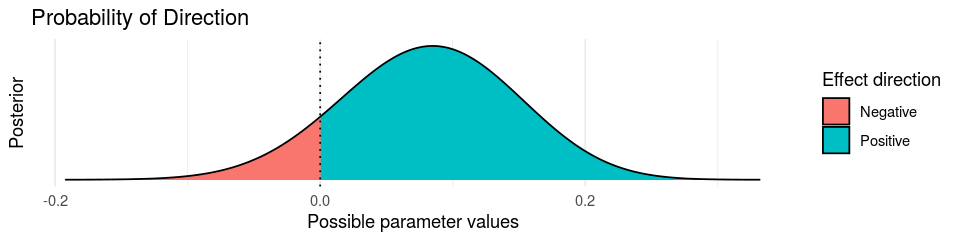

In [272]:
n = 15
k = 12

options(repr.plot.width = 8, repr.plot.height = 2)

# Scenario A (regular coin)
posterior = distribution_beta(10000, 20+k, 20+n-k)
p_direction(posterior-.5) %T>% print() %>% plot()

In [363]:
# Scenario A (regular coin)
alpha = 20
beta = 20
n = 50
k = 38
posterior = distribution_beta(10000, alpha+k, beta+n-k)


p_direction(posterior-.5) %T>%
    print() %>%
    plot() + expand_limits(x=c(-.5,.5))

pd = 99.73%

#### Regions of practical equivalence (ROPE)
See https://easystats.github.io/bayestestR/articles/region_of_practical_equivalence.html

*"The null hypothesis is rejected or accepted if the percentage of the posterior within the ROPE is smaller than to 2.5% or greater than 97.5% (...) Else, it’s unclear whether the null hypothesis should be accepted or rejected."*

# Proportion of samples inside the ROPE [0.45, 0.55]:

inside ROPE
-----------
1.15 %     



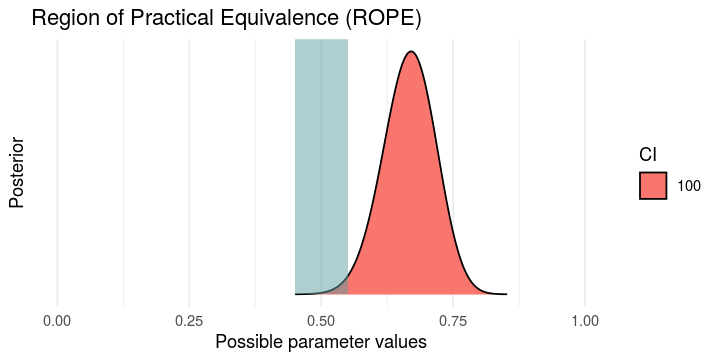

In [81]:
n = 50
k = 40
posterior = distribution_beta(10000, alpha+k, beta+n-k)

options(repr.plot.width = 6, repr.plot.height = 3)

rope(posterior, range = c(.45,.55), ci=1) %T>%
    print() %>%
    plot() + expand_limits(x=c(0,1))

# Very little "belief" is included in the ROPE, so we can REJECT the null hypothesis for all practical purposes

In [85]:
n = 5
k = 4
posterior = distribution_beta(10000, alpha+k, beta+n-k)

options(repr.plot.width = 6, repr.plot.height = 3)

rope(posterior, range = c(.45,.55), ci=1) %T>%
    print() %>%
    plot() + expand_limits(x=c(0,1))

# The ROPE is included in or overlapping with the CI => we can't conclude

# Proportion of samples inside the ROPE [0.45, 0.55]:

inside ROPE
-----------
45.45 %    



# Proportion of samples inside the ROPE [0.45, 0.55]:

inside ROPE
-----------
98.02 %    



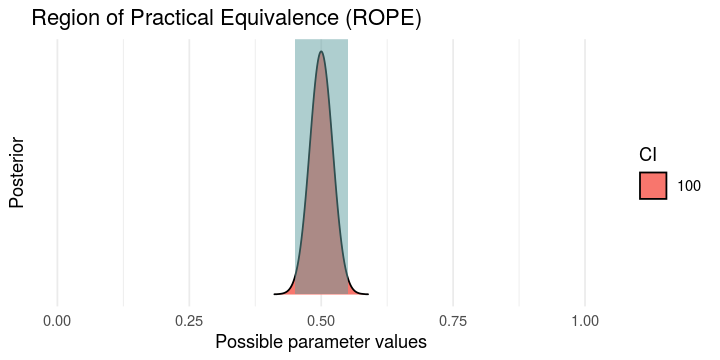

In [84]:
alpha = 20
beta = 20

n = 500
k = 250
posterior = distribution_beta(10000, alpha+k, beta+n-k)

options(repr.plot.width = 6, repr.plot.height = 3)

rope(posterior, range = c(.45,.55), ci=1) %T>%
    print() %>%
    plot() + expand_limits(x=c(0,1))

# So much "belief" is included in the ROPE that we can ACCEPT the null hypothesis for all practical purposes

### Two-sample location test

= testing whether 2 groups have different means

In [164]:
library(BEST)

In [117]:
# Create dataset
y1 <- c(5.77, 5.33, 4.59, 4.33, 3.66, 4.48)
y2 <- c(3.88, 3.55, 3.29, 2.59, 2.33, 3.59)

In [166]:
t.test(y1,y2)


	Welch Two Sample t-test

data:  y1 and y2
t = 3.7624, df = 9.6093, p-value = 0.003977
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.6020466 2.3746201
sample estimates:
mean of x mean of y 
 4.693333  3.205000 


In [165]:
# Fit the model
BESTout <- BESTmcmc(y1, y2, parallel=T)

Waiting for parallel processing to complete...done.


In [169]:
summary(BESTout)

mean       median     mode      HDI% HDIlo      HDIup     compVal
mu1        4.6873837  4.6854191 4.6894205 95    3.7501412  5.620667 NA     
mu2        3.2202716  3.2230416 3.2422753 95    2.4530308  3.998766 NA     
muDiff     1.4671122  1.4633279 1.4255253 95    0.2045020  2.645567  0     
sigma1     1.0121867  0.8842290 0.7309095 95    0.3663270  1.976668 NA     
sigma2     0.8353701  0.7287251 0.6039401 95    0.2894595  1.629885 NA     
sigmaDiff  0.1768166  0.1455523 0.1165005 95   -1.1594515  1.543023  0     
nu        33.6766723 24.9980785 8.9679379 95    1.0088382 92.296222 NA     
log10nu    1.3629386  1.3979066 1.5156768 95    0.5456281  2.095214 NA     
effSz      1.7008905  1.6812821 1.6079724 95    0.1536686  3.263473  0     
          %>compVal ROPElow ROPEhigh %InROPE
mu1             NA  NA      NA       NA     
mu2             NA  NA      NA       NA     
muDiff    98.68703  NA      NA       NA     
sigma1          NA  NA      NA       NA     
sigma2          NA  NA      NA       NA     
sigmaDiff 63.52673  NA      NA       NA     
nu              NA  NA      NA       NA     
log10nu         NA  NA      NA       NA     
effSz     98.68703  NA      NA       NA

In [170]:
# The results can also be inspected using functions from the  bayestestR package
bayestestR::describe_posterior(BESTout, ci=0.9)

Parameter Median     CI CI_low    CI_high   pd      ROPE_CI ROPE_low
1 mu1        4.6854191 90 3.9768574  5.417912 0.99997 89      -0.1    
2 mu2        3.2230416 90 2.6189876  3.808332 0.99995 89      -0.1    
3 nu        24.9980785 90 1.0543562 71.966148 1.00000 89      -0.1    
4 sigma1     0.8842290 90 0.4017925  1.626178 1.00000 89      -0.1    
5 sigma2     0.7287251 90 0.3371292  1.350120 1.00000 89      -0.1    
  ROPE_high ROPE_Percentage
1 0.1       0              
2 0.1       0              
3 0.1       0              
4 0.1       0              
5 0.1       0

In [120]:
# Visualize results: MEANS

plot(BESTout, credMass=0.9, ROPE = c(-0.1,0.1), compVal = NULL)

In [179]:
# Visualize results: SD

plot(BESTout, credMass=0.9, which="nu")

### Correlation

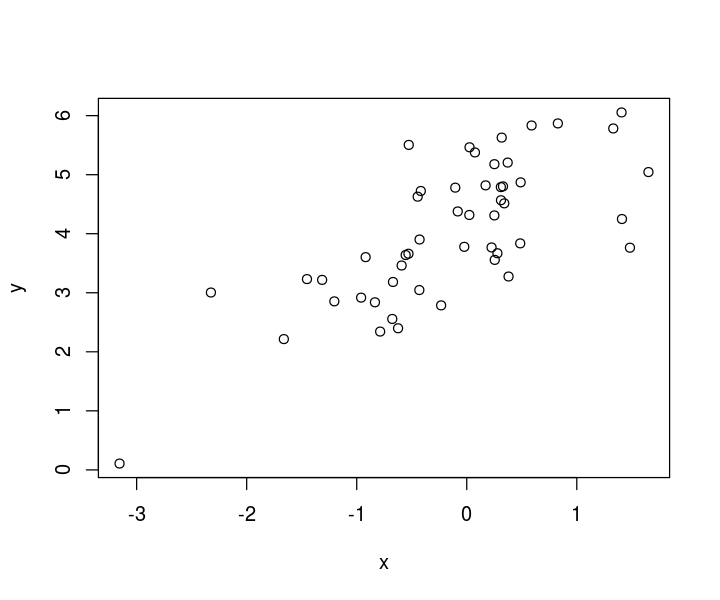

In [171]:
# Create data
x = rnorm(50, 0, 1)
y = 4 + x + rnorm(50,0,0.8)

plot(x,y)

In [172]:
library(BayesianFirstAid)

In [173]:
bct <- bayes.cor.test(x,y)
bct


	Bayesian First Aid Pearson's Correlation Coefficient Test

data: x and y (n = 50)
Estimated correlation:
  0.71 
95% credible interval:
  0.54 0.84 
The correlation is more than 0 by a probability of >0.999 
and less than 0 by a probability of <0.001 


In [174]:
cor.test(x,y)


	Pearson's product-moment correlation

data:  x and y
t = 7.4258, df = 48, p-value = 1.641e-09
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.5685451 0.8388117
sample estimates:
      cor 
0.7311811 


In [150]:
summary(bct)

  Data
x and y, n = 50

  Model parameters
rho: the correlation between x and y 
mu[1]: the mean of x 
sigma[1]: the scale of x , a consistent
  estimate of SD when nu is large.
mu[2]: the mean of y 
sigma[2]: the scale of y 
nu: the degrees-of-freedom for the bivariate t distribution
xy_pred[1]: the posterior predictive distribution of x 
xy_pred[2]: the posterior predictive distribution of y 

  Measures
             mean     sd  HDIlo  HDIup %<comp %>comp
rho         0.792  0.059  0.680  0.899  0.000  1.000
mu[1]      -0.028  0.162 -0.342  0.300  0.569  0.431
mu[2]       4.071  0.228  3.633  4.529  0.000  1.000
sigma[1]    1.086  0.125  0.841  1.327  0.000  1.000
sigma[2]    1.508  0.173  1.171  1.843  0.000  1.000
nu         33.482 27.629  2.853 89.353  0.000  1.000
xy_pred[1] -0.034  1.177 -2.351  2.256  0.509  0.491
xy_pred[2]  4.062  1.626  0.780  7.204  0.009  0.991

'HDIlo' and 'HDIup' are the limits of a 95% HDI credible interval.
'%<comp' and '%>comp' are the probabilities o

In [147]:
# The results can also be inspected using functions from the  bayestestR package
describe_posterior(bct)

ERROR: Error in UseMethod("describe_posterior"): no applicable method for 'describe_posterior' applied to an object of class "c('bayes_cor_test', 'bayesian_first_aid')"


In [175]:
options(repr.plot.width = 6, repr.plot.height = 5)

plot(bct)

### Linear model

In [127]:
library(rstan)

Loading required package: StanHeaders
rstan (Version 2.17.3, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)

Attaching package: ‘rstan’

The following object is masked from ‘package:coda’:

    traceplot

The following object is masked from ‘package:tidyr’:

    extract



In [128]:
head(iris)

Sepal.Length Sepal.Width Petal.Length Petal.Width Species
1 5.1          3.5         1.4          0.2         setosa 
2 4.9          3.0         1.4          0.2         setosa 
3 4.7          3.2         1.3          0.2         setosa 
4 4.6          3.1         1.5          0.2         setosa 
5 5.0          3.6         1.4          0.2         setosa 
6 5.4          3.9         1.7          0.4         setosa

`geom_smooth()` using formula 'y ~ x'


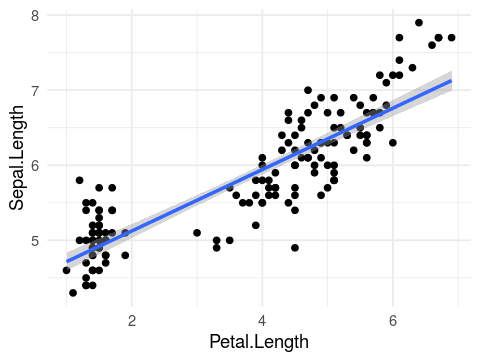

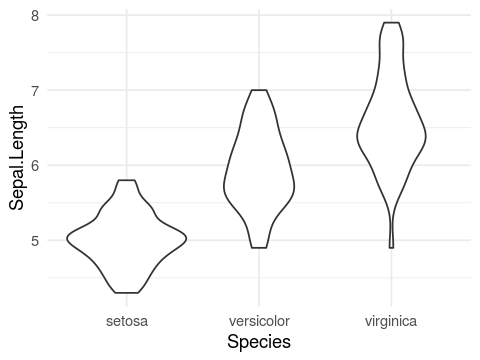

In [132]:
options(repr.plot.width = 4, repr.plot.height = 3)

ggplot(iris, aes(x=Petal.Length, y=Sepal.Length)) +
  geom_point() + 
  geom_smooth(method="lm")

ggplot(iris, aes(x=Species, y=Sepal.Length)) +
  geom_violin()

In [135]:
# install.packages("rstanarm")
library(rstanarm)

ERROR: Error in library(rstanarm): there is no package called ‘rstanarm’


In [133]:
model <- stan_glm(Sepal.Length ~ Petal.Length + Species, data=iris)
summary(model)

ERROR: Error in stan_glm(Sepal.Length ~ Petal.Length + Species, data = iris): could not find function "stan_glm"


## Based on the Bayes Factor (BF)

### Savage-Dickey density ratio
This is the equivalent of Bayes Factor for an exact (i.e. point-restricted) hypothesis 

In [184]:
# Scenario A (regular coin)
n = 500
k = 250
alpha = 20
beta = 20
prior = distribution_beta(1000, alpha, beta)
posterior = distribution_beta(1000, alpha+k, beta+n-k)

bf_parameters(posterior,prior,null = .5) %T>% print() %>% plot()

# Bayes Factor (Savage-Dickey density ratio)

BF   
-----
0.275

* Evidence Against The Null: [0.5]


### BF

In [187]:
n = 5
k = 4
alpha = 20
beta = 20

prior = distribution_beta(1000, alpha, beta)
posterior = distribution_beta(1000, alpha+k, beta+n-k)

# Bayes Factor (Null-Interval)

BF   
-----
1.086

* Evidence Against The Null: [0.45, 0.55]


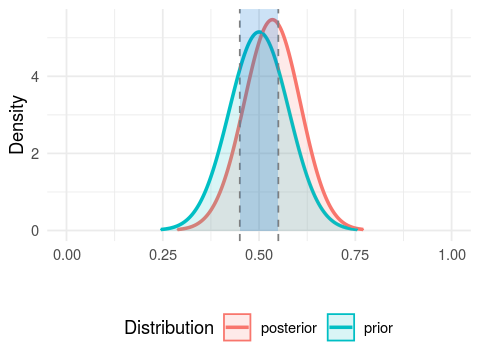

In [188]:
# BF against negligible effect
options(repr.plot.width = 4, repr.plot.height = 3)
bf_parameters(posterior,prior,null = c(0.45,0.55)) %T>%
    print() %>%
    plot() + expand_limits(x=c(0,1))

# Support Interval

BF = 10 SI  
------------
[0.65, 0.79]



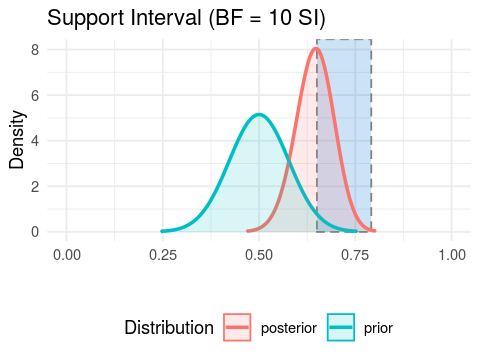

In [350]:
si(posterior, prior, BF = 10) %T>% print() %>% plot() + expand_limits(x=c(0,1))

### Two-sample location test

In [189]:
library(BayesFactor)

In [190]:
y1 <- c(5.77, 5.33, 4.59, 4.33, 3.66, 4.48)
y2 <- c(3.88, 3.55, 3.29, 2.59, 2.33, 3.59)

bf = ttestBF(y1,y2)
bf

Bayes factor analysis
--------------
[1] Alt., r=0.707 : 10.56097 ±0%

Against denominator:
  Null, mu1-mu2 = 0 
---
Bayes factor type: BFindepSample, JZS


In [191]:
describe_posterior(bf)

Parameter  Median   CI CI_low    CI_high  pd     ROPE_CI ROPE_low ROPE_high
1 Difference 1.216214 89 0.4698829 1.971448 0.9925 89      -0.1     0.1      
  ROPE_Percentage BF       Prior_Distribution Prior_Location Prior_Scale
1 0               10.56097 cauchy             0              0.7071068

# Informative priors

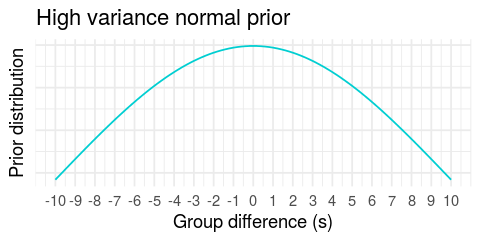

In [485]:
# Let's set a high variance normal prior

options(repr.plot.width = 4, repr.plot.height = 2)

ggplot(data.frame(), aes()) +
stat_function(fun = dnorm, args = list(sd = 10), color = "darkturquoise", size = linewidth) +
expand_limits(x = c(-10,10)) +
scale_x_continuous(breaks = seq(-10,10,1)) +
labs(x = "Group difference (s)", y = "Prior distribution", title = "High variance normal prior") +
theme(axis.text.y = element_blank())

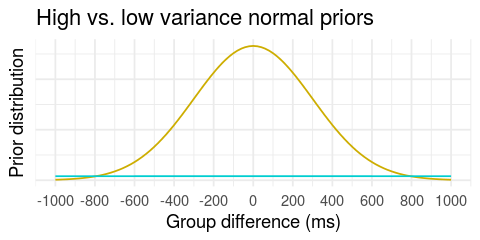

In [487]:
# Compared to a much smaller variance prior, the high variance one appears flat, and therefore non-informative

options(repr.plot.width = 4, repr.plot.height = 2)

ggplot(data.frame(), aes()) +
stat_function(fun = dnorm, args = list(sd = 300), color = "gold3", size = linewidth) +
stat_function(fun = dnorm, args = list(sd = 10000), color = "darkturquoise", size = linewidth) +
expand_limits(x = c(-1000,1000)) +
scale_x_continuous(breaks = seq(-1000,1000,200)) +
labs(x = "Group difference (ms)", y = "Prior distribution", title = "High vs. low variance normal priors") +
theme(axis.text.y = element_blank())

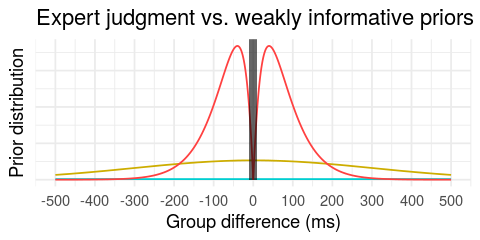

In [504]:
# However, as cognitive psychologists that differences in reaction times due to low-level mechanisms are
# in the order of tens of milliseconds, and are uninteresting below 10ms. We reflect this expert knowledge
# in a double, back-to-back gamma distribution

dgamma_sym = function(x,shape,scale){dgamma(-x,shape=shape,scale=scale)}

options(repr.plot.width = 4, repr.plot.height = 2)

gamma_shape = 2
gamma_scale = 40
linewidth = 0.5

ggplot(data.frame(), aes()) +
# annotate(geom = "segment", x = -30, xend = -30, y = 0, yend = dgamma(30, shape = gamma_shape, scale = gamma_scale)) +
stat_function(fun = dnorm, args = list(sd = 300), color = "gold3", size = linewidth) +
stat_function(fun = dnorm, args = list(sd = 10000), color = "darkturquoise", size = linewidth) +
stat_function(fun = dgamma, args = list(shape = gamma_shape, scale = gamma_scale),
              xlim = c(0,500), n=1000, color = "brown1", size = linewidth) +
stat_function(fun = dgamma_sym, args = list(shape = gamma_shape, scale = gamma_scale),
              xlim = c(-500,0), n=1000, color = "brown1", size = linewidth) +
annotate(geom = "rect", xmin = -10, xmax = 10, ymin = 0, ymax = Inf, fill = "black", alpha = .6) +
expand_limits(x = c(-500,500)) +
scale_x_continuous(breaks = seq(-500,500,100)) +
labs(x = "Group difference (ms)", y = "Prior distribution", title = "Expert judgment vs. weakly informative priors") +
theme(axis.text.y = element_blank())

# **Convert this notebook to R markdown**

In [192]:
library(rmarkdown)
input = "2-03.ipynb"
rmarkdown:::convert_ipynb(input, output = xfun::with_ext(input, "Rmd"))